In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the data
url = 'nvidia_stock_cleaned.csv'
df_cleaned = pd.read_csv(url)
df_cleaned

# Load the stock news data
url = 'stocknews.csv'
df_news = pd.read_csv(url)
df_news

,date,news
0,2017-08-18,Mark Zuckerberg's philanthropic fund just hire...
1,2017-08-19,Travis Kalanick lasted in his role for 6.5 yea...
2,2017-08-21,A top Facebook analyst has a $21 billion quest...
3,2017-08-22,Ad giant WPP: 'Our industry may be in danger o...
4,2017-08-23,Mark Cuban is trying to fix social media's big...
...,...,...
2308,2024-06-18,Retire Rich: 3 Powerhouse Stocks to Buy for Lo...
2309,2024-06-19,Why Piper Sandler Is Pounding the Table on Adv...
2310,2024-06-20,S&P 500 Predictions 2024: 3 Recent Price Targe...
2311,2024-06-21,Growth Stocks Leave Value Stocks In The Dust: ...


In [ ]:
import pandas as pd
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk

nltk.download('vader_lexicon')

# Initialize VADER
sia = SentimentIntensityAnalyzer()

# Ensure dates are in datetime format
df_news['date'] = pd.to_datetime(df_news['date'])

# Apply VADER sentiment analysis
df_news['sentiment'] = df_news['news'].apply(lambda x: sia.polarity_scores(x)['compound'])

# Print sentiment results
print("News Data with Sentiment Scores:")
print(df_news)

# Merge with Stock Data
df_cleaned['date'] = pd.to_datetime(df_cleaned['date'])
merged_df = pd.merge(df_cleaned, df_news.groupby('date')['sentiment'].mean().reset_index(), on='date', how='left')

# Fill missing sentiment values with 0 (assume neutral sentiment for missing days)
merged_df['sentiment'].fillna(0, inplace=True)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


News Data with Sentiment Scores:
           date                                               news  sentiment
0    2017-08-18  Mark Zuckerberg's philanthropic fund just hire...     0.0000
1    2017-08-19  Travis Kalanick lasted in his role for 6.5 yea...     0.0000
2    2017-08-21  A top Facebook analyst has a $21 billion quest...     0.2023
3    2017-08-22  Ad giant WPP: 'Our industry may be in danger o...    -0.3400
4    2017-08-23  Mark Cuban is trying to fix social media's big...     0.2960
...         ...                                                ...        ...
2308 2024-06-18  Retire Rich: 3 Powerhouse Stocks to Buy for Lo...     0.9823
2309 2024-06-19  Why Piper Sandler Is Pounding the Table on Adv...     0.9367
2310 2024-06-20  S&P 500 Predictions 2024: 3 Recent Price Targe...     0.9860
2311 2024-06-21  Growth Stocks Leave Value Stocks In The Dust: ...     0.5859
2312 2024-06-22  Invest in Promising AI Stocks Before the Disin...     0.4019

[2313 rows x 3 columns]


<ipython-input-4-fa0959feeefd>:25: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  merged_df['sentiment'].fillna(0, inplace=True)


In [ ]:
# Ensure 'daily_return' exists
merged_df['daily_return'] = merged_df['close'].pct_change()

# Calculate rolling volatility (10-day window)
merged_df['volatility'] = merged_df['daily_return'].rolling(window=10).std()

# Drop NaN values created by calculations
merged_df = merged_df.dropna()

# Select features to include
features = ['close', 'volume', 'sentiment', 'volatility', 'daily_return']

# Confirm features exist
print("Available columns in DataFrame:", merged_df.columns)

# Proceed with scaling and model training
data = merged_df[features].values

Available columns in DataFrame: Index(['date', 'open', 'high', 'low', 'close', 'adjclose', 'volume',
       'sentiment', 'daily_return', 'volatility'],
      dtype='object')


In [ ]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Feature Scaling
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

# Function to create sequences for multivariate time series
def create_sequences_multivariate(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length, 0])  # Predicting 'close' price
    return np.array(X), np.array(y)

SEQ_LENGTH = 30  # Number of past days to consider
X, y = create_sequences_multivariate(data_scaled, SEQ_LENGTH)

In [ ]:
# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [ ]:
# Build LSTM Model
model = Sequential([
    LSTM(64, activation='relu', return_sequences=True, input_shape=(SEQ_LENGTH, X.shape[2])),
    Dropout(0.2),
    LSTM(32, activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(1)
])

model.compile(optimizer='adam', loss='mse')


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
# Train the Model
history = model.fit(X_train, y_train, epochs=50, batch_size=32,
                    validation_data=(X_test, y_test), verbose=1)

Epoch 1/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 54ms/step - loss: 0.0074 - val_loss: 0.0196
Epoch 2/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 34ms/step - loss: 0.0012 - val_loss: 0.0117
Epoch 3/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 6.9398e-04 - val_loss: 0.0023
Epoch 4/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 62ms/step - loss: 3.4986e-04 - val_loss: 0.0025
Epoch 5/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 6s 75ms/step - loss: 3.4423e-04 - val_loss: 0.0028
Epoch 6/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 3.5225e-04 - val_loss: 0.0027
Epoch 7/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - loss: 2.8162e-04 - val_loss: 0.0083
Epoch 8/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 2.4024e-04 - val_loss: 0.0044
Epoch 9/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 39ms/step - loss: 2.3894e-04 - val_loss: 0.0025
Epoch 10/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 2.1756e-04 - val_loss: 0.0058
Epoch 11/50
59/59 ━━━━━━━━━━━━━━━━━━━━ 2s 36ms/step - loss: 2.3831e-04 - val_loss: 0.0097
Epoch 12/50
59/59 ━━━━━━━━━

In [ ]:
# Predict on the Test Set
y_pred = model.predict(X_test)

15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


In [ ]:
# Inverse Transform Predictions
# We need to inverse transform only the 'close' price (first feature)
y_test_inv = scaler.inverse_transform(
    np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), data.shape[1]-1))), axis=1)
)[:, 0]
y_pred_inv = scaler.inverse_transform(
    np.concatenate((y_pred, np.zeros((len(y_pred), data.shape[1]-1))), axis=1)
)[:, 0]

Mean Absolute Error (MAE): 23.2586
Root Mean Squared Error (RMSE): 31.7761


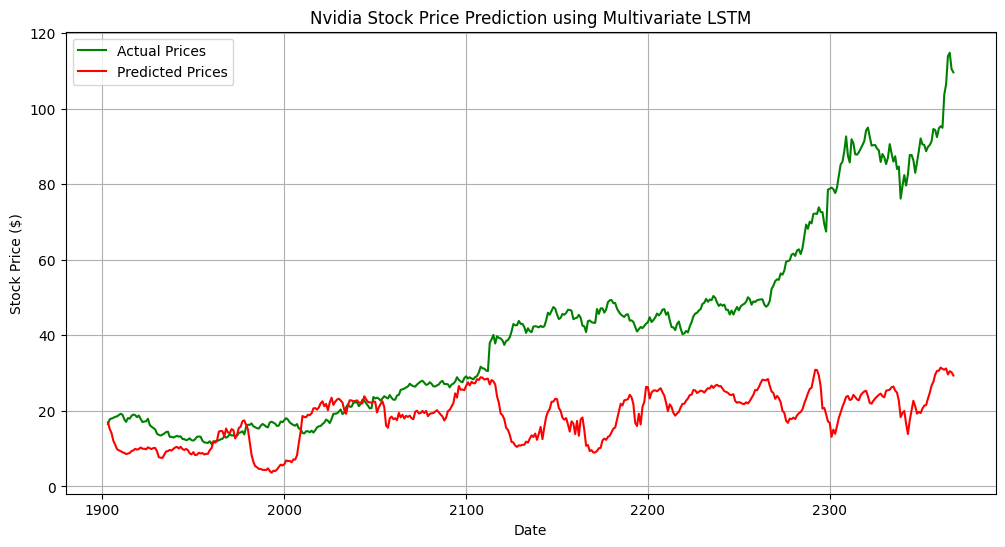

In [ ]:
# Evaluate the Model
baseline_mae = mean_absolute_error(y_test_inv, y_pred_inv)
baseline_rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))
baseline_mse = mean_squared_error(y_test_inv, y_pred_inv)
print(f"Mean Absolute Error (MAE): {baseline_mae:.4f}")
print(f"Root Mean Squared Error (RMSE): {baseline_rmse:.4f}")

# Plot Actual vs Predicted Prices
dates = merged_df.index[SEQ_LENGTH + train_size:]

plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_inv, label='Actual Prices', color='green')
plt.plot(dates, y_pred_inv, label='Predicted Prices', color='red')
plt.title("Nvidia Stock Price Prediction using Multivariate LSTM")
plt.xlabel("Date")
plt.ylabel("Stock Price ($)")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Build LSTM Model
model = Sequential([
    LSTM(128, activation='relu', return_sequences=True, input_shape=(SEQ_LENGTH, X.shape[2])),
    Dropout(0.3),
    LSTM(64, activation='relu', return_sequences=False),
    Dense(1)
])

# Compile the model
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the Model
history = model.fit(X_train, y_train, epochs=100, batch_size=32,
                    validation_data=(X_test, y_test), callbacks=[early_stopping])

# Predict on the Test Set
y_pred = model.predict(X_test)


Epoch 1/100


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


59/59 ━━━━━━━━━━━━━━━━━━━━ 11s 133ms/step - loss: 0.0058 - mae: 0.0575 - val_loss: 0.0692 - val_mae: 0.2007
Epoch 2/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 0.0017 - mae: 0.0291 - val_loss: 0.0858 - val_mae: 0.2249
Epoch 3/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 71ms/step - loss: 0.0016 - mae: 0.0273 - val_loss: 0.0667 - val_mae: 0.1861
Epoch 4/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 109ms/step - loss: 0.0012 - mae: 0.0238 - val_loss: 0.0756 - val_mae: 0.2011
Epoch 5/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 8s 70ms/step - loss: 0.0013 - mae: 0.0234 - val_loss: 0.0775 - val_mae: 0.2034
Epoch 6/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 7s 105ms/step - loss: 0.0011 - mae: 0.0216 - val_loss: 0.0753 - val_mae: 0.1996
Epoch 7/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 9.9839e-04 - mae: 0.0205 - val_loss: 0.0719 - val_mae: 0.1945
Epoch 8/100
59/59 ━━━━━━━━━━━━━━━━━━━━ 4s 69ms/step - loss: 8.9275e-04 - mae: 0.0199 - val_loss: 0.0724 - val_mae: 0.1946
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 68ms/step


Testing: seq_length=30, units=32, batch_size=16, epochs=20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
Testing: seq_length=30, units=32, batch_size=16, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step
Testing: seq_length=30, units=32, batch_size=32, epochs=20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Testing: seq_length=30, units=32, batch_size=32, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Testing: seq_length=30, units=64, batch_size=16, epochs=20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Testing: seq_length=30, units=64, batch_size=16, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step
Testing: seq_length=30, units=64, batch_size=32, epochs=20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Testing: seq_length=30, units=64, batch_size=32, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Testing: seq_length=60, units=32, batch_size=16, epochs=20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Testing: seq_length=60, units=32, batch_size=16, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Testing: seq_length=60, units=32, batch_size=32, epochs=20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Testing: seq_length=60, units=32, batch_size=32, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step
Testing: seq_length=60, units=64, batch_size=16, epochs=20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step
Testing: seq_length=60, units=64, batch_size=16, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step
Testing: seq_length=60, units=64, batch_size=32, epochs=20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Testing: seq_length=60, units=64, batch_size=32, epochs=50


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step

Best Parameters: seq_length=30, units=64, batch_size=16, epochs=20 with RMSE: 2.1518


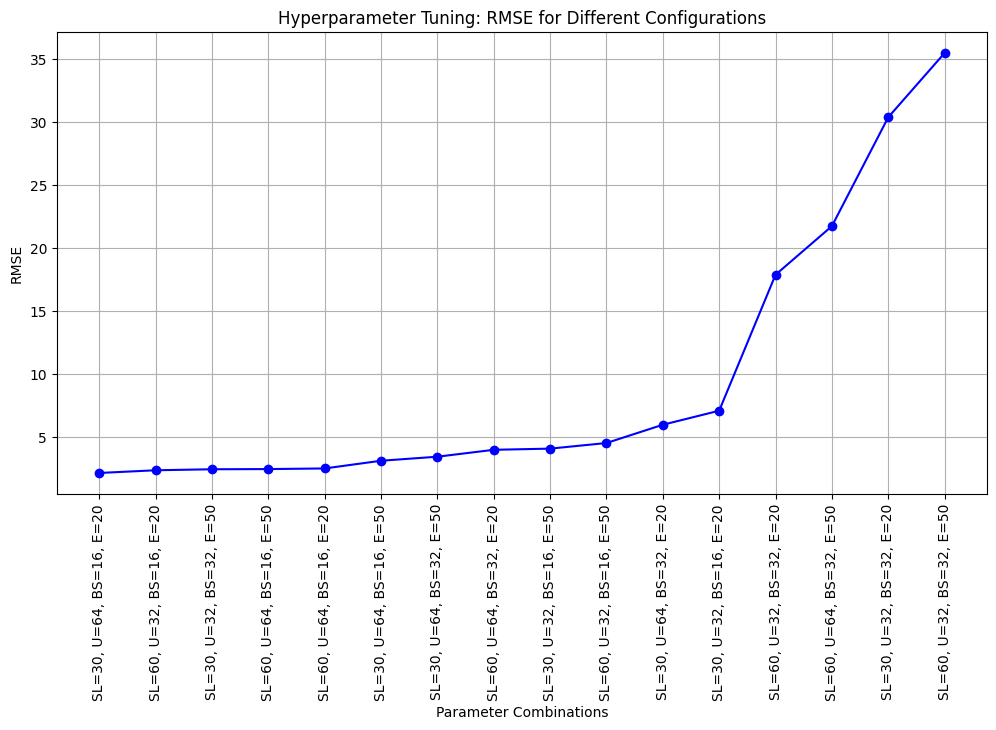

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt

# Function to create sequences for LSTM
def create_sequences_multivariate(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i + seq_length])
        y.append(data[i + seq_length, 0])  # Predicting 'close' price
    return np.array(X), np.array(y)

# Function to build LSTM model
def build_lstm_model(input_shape, units):
    model = Sequential([
        LSTM(units, activation='relu', input_shape=input_shape),
        Dropout(0.2),
        Dense(1)
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='mse')
    return model

# Walk-forward validation function
def walk_forward_validation(data, seq_length, units, batch_size, epochs):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data)

    train_size = int(len(scaled_data) * 0.8)
    train, test = scaled_data[:train_size], scaled_data[train_size:]

    # Create sequences
    X_train, y_train = create_sequences_multivariate(train, seq_length)
    X_test, y_test = create_sequences_multivariate(test, seq_length)

    # Build and train the model
    model = build_lstm_model((X_train.shape[1], X_train.shape[2]), units)
    model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    # Predict and evaluate
    y_pred = model.predict(X_test)
    y_test_inv = scaler.inverse_transform(np.concatenate((y_test.reshape(-1, 1), np.zeros((len(y_test), data.shape[1]-1))), axis=1))[:, 0]
    y_pred_inv = scaler.inverse_transform(np.concatenate((y_pred, np.zeros((len(y_pred), data.shape[1]-1))), axis=1))[:, 0]

    return np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

# Hyperparameter grid
param_grid = {
    'seq_length': [30, 60],
    'units': [32, 64],
    'batch_size': [16, 32],
    'epochs': [20, 50]
}

# Data preparation
data = merged_df[['close', 'volume', 'sentiment', 'volatility', 'daily_return']].values

# Grid Search
results = []
for params in itertools.product(*param_grid.values()):
    seq_length, units, batch_size, epochs = params
    print(f"Testing: seq_length={seq_length}, units={units}, batch_size={batch_size}, epochs={epochs}")
    rmse = walk_forward_validation(data, seq_length, units, batch_size, epochs)
    results.append((params, rmse))

# Sort results by RMSE
results.sort(key=lambda x: x[1])

# Display Best Parameters
best_params, best_rmse = results[0]
print(f"\nBest Parameters: seq_length={best_params[0]}, units={best_params[1]}, "
      f"batch_size={best_params[2]}, epochs={best_params[3]} with RMSE: {best_rmse:.4f}")

# Plot RMSE for all configurations
rmse_values = [result[1] for result in results]
param_combinations = [f"SL={p[0]}, U={p[1]}, BS={p[2]}, E={p[3]}" for p, _ in results]

plt.figure(figsize=(12, 6))
plt.plot(param_combinations, rmse_values, marker='o', linestyle='-', color='b')
plt.xticks(rotation=90)
plt.title("Hyperparameter Tuning: RMSE for Different Configurations")
plt.xlabel("Parameter Combinations")
plt.ylabel("RMSE")
plt.grid(True)
plt.show()


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


117/117 ━━━━━━━━━━━━━━━━━━━━ 7s 22ms/step - loss: 0.0039
Epoch 2/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0019
Epoch 3/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 19ms/step - loss: 0.0018
Epoch 4/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0014
Epoch 5/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0013
Epoch 6/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0013
Epoch 7/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0011
Epoch 8/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 0.0011
Epoch 9/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 8.9958e-04
Epoch 10/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 9.6820e-04
Epoch 11/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 8.2096e-04
Epoch 12/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 7.6702e-04
Epoch 13/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - loss: 8.5795e-04
Epoch 14/20
117/117 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 6.9401e-04
Epoch 15/20
117/117 ━━━━━━━━━━

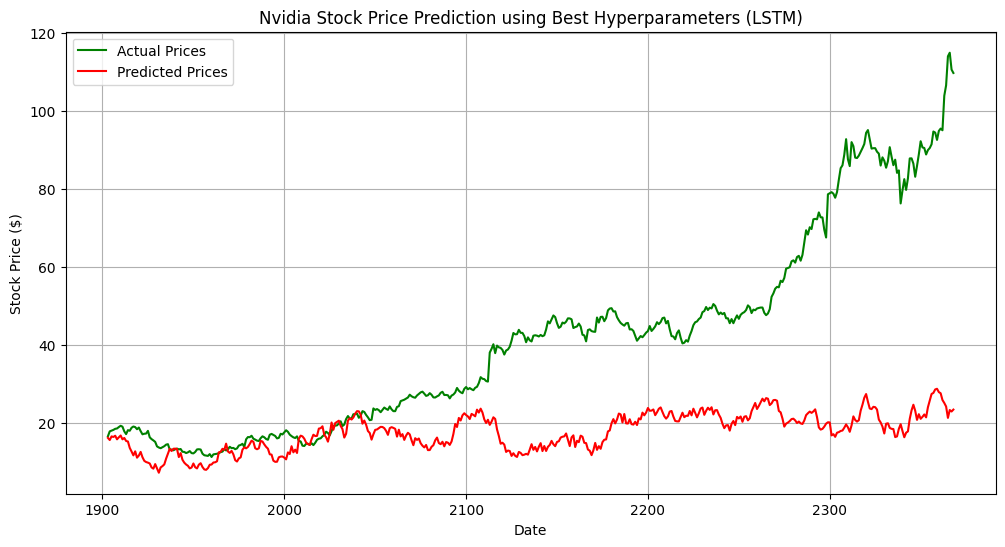

In [ ]:
# Extract Best Parameters
best_seq_length, best_units, best_batch_size, best_epochs = best_params
# Prepare target (close price) and features separately
target = merged_df['close'].values.reshape(-1, 1)
features = merged_df[['volume', 'sentiment', 'volatility', 'daily_return']].values

# Scale target (close price)
scaler_target = MinMaxScaler(feature_range=(0, 1))
target_scaled = scaler_target.fit_transform(target)

# Scale features
scaler_features = MinMaxScaler(feature_range=(0, 1))
features_scaled = scaler_features.fit_transform(features)

# Combine scaled features and target for LSTM input
data_scaled = np.hstack((target_scaled, features_scaled))

# Function to create sequences
def create_sequences_multivariate(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length, 1:])  # Use features (exclude 'close')
        y.append(data[i+seq_length, 0])     # Predict 'close' price
    return np.array(X), np.array(y)

# Create sequences
SEQ_LENGTH = best_seq_length  # From hyperparameter tuning
X, y = create_sequences_multivariate(data_scaled, SEQ_LENGTH)

# Train-test split
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# Build and train LSTM model
final_model = Sequential([
    LSTM(best_units, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    Dense(1)
])
final_model.compile(optimizer='adam', loss='mse')

final_model.fit(X_train, y_train, epochs=best_epochs, batch_size=best_batch_size, verbose=1)

# Predict
y_pred = final_model.predict(X_test)

# Inverse transform only the 'close' price
y_test_inv = scaler_target.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler_target.inverse_transform(y_pred)

# Plot Actual vs Predicted Prices
dates = merged_df.index[-len(y_test):]

plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_inv, label='Actual Prices', color='green')
plt.plot(dates, y_pred_inv, label='Predicted Prices', color='red')
plt.title("Nvidia Stock Price Prediction using Best Hyperparameters (LSTM)")
plt.xlabel("Date")
plt.ylabel("Stock Price ($)")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Calculate evaluation metrics
tuned_mse = mean_squared_error(y_test_inv, y_pred_inv)
tuned_mae = mean_absolute_error(y_test_inv, y_pred_inv)
tuned_rmse = np.sqrt(tuned_mse)

In [ ]:
# Example comparison table
results = {
    "Model": ["Baseline LSTM", "Tuned LSTM"],
    "MSE": [baseline_mse, tuned_mse],
    "MAE": [baseline_mae, tuned_mae],
    "RMSE": [baseline_rmse, tuned_rmse],
}

import pandas as pd
results_df = pd.DataFrame(results)
print(results_df)

           Model          MSE        MAE       RMSE
0  Baseline LSTM  1009.721423  23.258571  31.776114
1     Tuned LSTM  1071.038714  23.815340  32.726728


<ipython-input-36-859b5ca499c6>:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0].set_xticklabels(models, rotation=45)
<ipython-input-36-859b5ca499c6>:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[1].set_xticklabels(models, rotation=45)
<ipython-input-36-859b5ca499c6>:20: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[2].set_xticklabels(models, rotation=45)


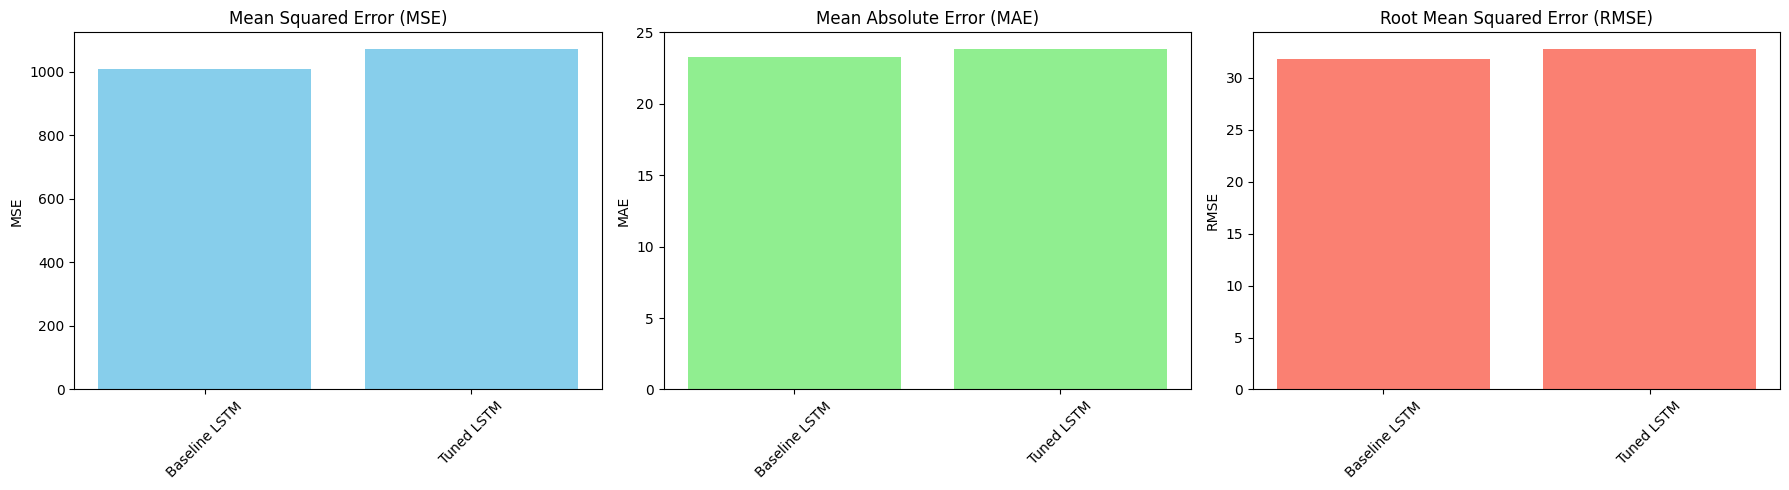

In [ ]:
# Plot MSE, MAE, RMSE as Bar Charts
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# MSE
axes[0].bar(results_df['Model'], results_df['MSE'], color='skyblue')
axes[0].set_title('Mean Squared Error (MSE)')
axes[0].set_ylabel('MSE')
axes[0].set_xticklabels(models, rotation=45)

# MAE
axes[1].bar(results_df['Model'], results_df['MAE'], color='lightgreen')
axes[1].set_title('Mean Absolute Error (MAE)')
axes[1].set_ylabel('MAE')
axes[1].set_xticklabels(models, rotation=45)

# RMSE
axes[2].bar(results_df['Model'], results_df['RMSE'], color='salmon')
axes[2].set_title('Root Mean Squared Error (RMSE)')
axes[2].set_ylabel('RMSE')
axes[2].set_xticklabels(models, rotation=45)

# Adjust layout
plt.tight_layout()
plt.show()

# **Insights:**

1. No Significant Improvement:

Despite hyperparameter tuning, the performance metrics (MSE, MAE, and RMSE) remain very close to the Baseline LSTM.
This suggests that:

- The hyperparameters may not have been sufficiently optimized.

- The LSTM architecture or features may not fully capture the stock price dynamics.

2. Potential Causes:

- Overfitting: The Tuned LSTM might have overfitted the training data without generalizing well on unseen test data.

- Feature Limitations: The model might lack important features such as sentiment analysis scores, macroeconomic data, or product-specific event data.

- Sequence Length: Even with tuning, sequence lengths might not have been sufficient to capture long-term dependencies.

- RMSE and Outliers: The close RMSE values suggest that large errors (outliers) are not effectively reduced in the Tuned LSTM.